In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings(action='ignore')

!python -V
# print(sklearn.__version__)

Python 3.8.8


In [2]:
o_df = pd.read_csv('Tsimiski_st.csv', sep=',') # parse_dates = ['date_time'], index_col = ['date_time']

# Converting date_time format 
o_df['date_time'] = o_df['date_time'].astype('datetime64[ns]')
o_df['year'] = o_df['date_time'].dt.year

o_df.dropna(axis=0, how='any', inplace=True)

o_df

,osm_id,date_time,link_dir,speed_kmph,n_time,hours,mins,n_day,stores,n_month,highway,road_lt_m,bus_stop,year
0,13769164,2018-01-01 00:00:00,1,25,00:00,0,0,2,0,1,primary,72.0,no,2018
1,13769164,2018-01-01 00:15:00,1,22,00:15,0,15,2,0,1,primary,72.0,no,2018
2,13769164,2018-01-01 00:30:00,1,12,00:30,0,30,2,0,1,primary,72.0,no,2018
3,13769164,2018-01-01 00:45:00,1,4,00:45,0,45,2,0,1,primary,72.0,no,2018
4,13769164,2018-01-01 01:00:00,1,5,01:00,1,0,2,0,1,primary,72.0,no,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390917,176665188,2022-02-28 23:00:00,1,38,23:00,23,0,2,0,2,primary,542.0,yes,2022
390918,176665188,2022-02-28 23:15:00,1,43,23:15,23,15,2,0,2,primary,542.0,yes,2022
390919,176665188,2022-02-28 23:30:00,1,45,23:30,23,30,2,0,2,primary,542.0,yes,2022
390920,176665188,2022-02-28 23:45:00,1,43,23:45,23,45,2,0,2,primary,542.0,yes,2022


In [3]:
o_df['osm_id'].value_counts()

176665188    138889
174019380    130894
13769164     121139
Name: osm_id, dtype: int64

Text(0.5, 1.0, 'Speed Values in Tsimiski Street')

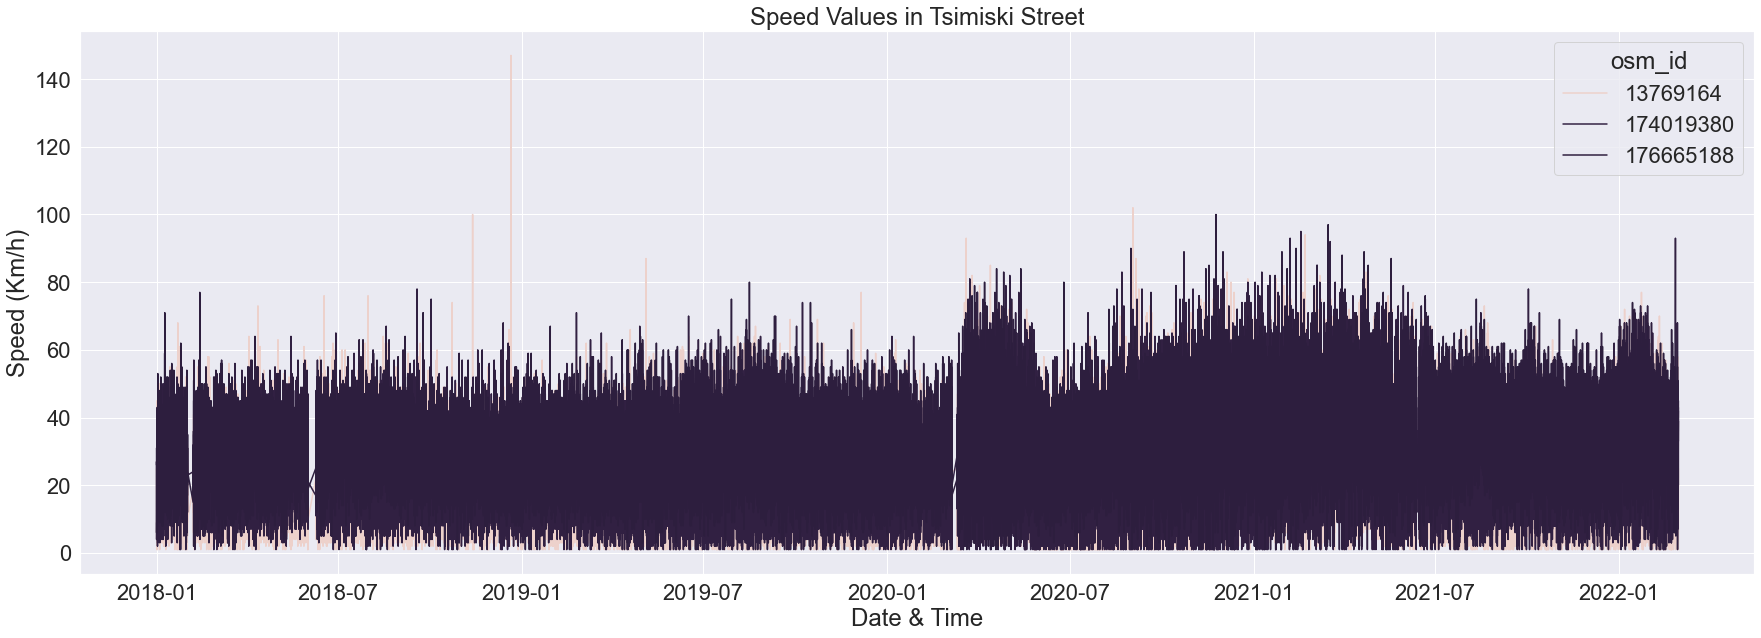

In [4]:
sns.set(rc={'figure.figsize':(30,10)}, font_scale=2)
sns.lineplot(x=o_df['date_time'], y=o_df['speed_kmph'], hue=o_df['osm_id'])
plt.ylabel('Speed (Km/h)')
plt.xlabel('Date & Time')
plt.title('Speed Values in Tsimiski Street')

In [5]:
# filter the data for processing 
# df = o_df.loc[o_df['year'] == 2018] 
# df = df.loc[df['osm_id'] == 176665188] # Change to df = df.loc[df['osm_id'] == 176665188] for multiple year analysis

#greater than the start date and smaller than the end date
mask = (o_df['date_time'] > '2021-01-01 00:00:00') & (o_df['date_time'] <= '2021-12-31 23:45:00') # selection format 2018-01-01 10:15:00
df = o_df.loc[mask]
df

,osm_id,date_time,link_dir,speed_kmph,n_time,hours,mins,n_day,stores,n_month,highway,road_lt_m,bus_stop,year
87392,13769164,2021-01-01 06:00:00,1,34,06:00,6,0,6,0,1,primary,72.0,no,2021
87393,13769164,2021-01-01 08:15:00,1,59,08:15,8,15,6,2,1,primary,72.0,no,2021
87394,13769164,2021-01-01 09:15:00,1,15,09:15,9,15,6,1,1,primary,72.0,no,2021
87395,13769164,2021-01-01 09:30:00,1,13,09:30,9,30,6,1,1,primary,72.0,no,2021
87396,13769164,2021-01-01 10:15:00,1,21,10:15,10,15,6,1,1,primary,72.0,no,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385376,176665188,2021-12-31 22:45:00,1,38,22:45,22,45,6,0,12,primary,542.0,yes,2021
385377,176665188,2021-12-31 23:00:00,1,33,23:00,23,0,6,0,12,primary,542.0,yes,2021
385378,176665188,2021-12-31 23:15:00,1,41,23:15,23,15,6,0,12,primary,542.0,yes,2021
385379,176665188,2021-12-31 23:30:00,1,34,23:30,23,30,6,0,12,primary,542.0,yes,2021


15 minutes = 4 step/hour
24 * 4 * 365 =  35040/id

Available:
96998/105120

In [6]:
# loop through id to create temp. df
osm = df['osm_id'].unique()

segments = {}
for i in range(len(osm)):
    segments['segment{}'.format(i+1)]=df[df['osm_id']==osm[i]]

ndf = pd.DataFrame()
# resample for each id
for segment in segments:
    dfs = segments[segment]
    dfs = dfs.set_index('date_time')
    dfs = dfs.resample('15T').interpolate()
    dfs = dfs.bfill()
# convert the type for some of the column
    dfs = dfs.astype({"osm_id":'int', "hours":'int', "mins":'int', "stores":'int', "n_day":'int', "n_month":'int', "year":'int'})

# append all temp. into one df
    ndf = ndf.append(dfs)
    df = ndf

In [7]:
df

,osm_id,link_dir,speed_kmph,n_time,hours,mins,n_day,stores,n_month,highway,road_lt_m,bus_stop,year
date_time,,,,,,,,,,,,,
2021-01-01 06:00:00,13769164,1.0,34.000000,06:00,6,0,6,0,1,primary,72.0,no,2021
2021-01-01 06:15:00,13769164,1.0,36.777778,08:15,6,1,6,0,1,primary,72.0,no,2021
2021-01-01 06:30:00,13769164,1.0,39.555556,08:15,6,3,6,0,1,primary,72.0,no,2021
2021-01-01 06:45:00,13769164,1.0,42.333333,08:15,6,5,6,0,1,primary,72.0,no,2021
2021-01-01 07:00:00,13769164,1.0,45.111111,08:15,6,6,6,0,1,primary,72.0,no,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 22:45:00,176665188,1.0,38.000000,22:45,22,45,6,0,12,primary,542.0,yes,2021
2021-12-31 23:00:00,176665188,1.0,33.000000,23:00,23,0,6,0,12,primary,542.0,yes,2021
2021-12-31 23:15:00,176665188,1.0,41.000000,23:15,23,15,6,0,12,primary,542.0,yes,2021


In [8]:
# Use only when multiple road segments are selected
df = df.reset_index()
df

,date_time,osm_id,link_dir,speed_kmph,n_time,hours,mins,n_day,stores,n_month,highway,road_lt_m,bus_stop,year
0,2021-01-01 06:00:00,13769164,1.0,34.000000,06:00,6,0,6,0,1,primary,72.0,no,2021
1,2021-01-01 06:15:00,13769164,1.0,36.777778,08:15,6,1,6,0,1,primary,72.0,no,2021
2,2021-01-01 06:30:00,13769164,1.0,39.555556,08:15,6,3,6,0,1,primary,72.0,no,2021
3,2021-01-01 06:45:00,13769164,1.0,42.333333,08:15,6,5,6,0,1,primary,72.0,no,2021
4,2021-01-01 07:00:00,13769164,1.0,45.111111,08:15,6,6,6,0,1,primary,72.0,no,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105085,2021-12-31 22:45:00,176665188,1.0,38.000000,22:45,22,45,6,0,12,primary,542.0,yes,2021
105086,2021-12-31 23:00:00,176665188,1.0,33.000000,23:00,23,0,6,0,12,primary,542.0,yes,2021
105087,2021-12-31 23:15:00,176665188,1.0,41.000000,23:15,23,15,6,0,12,primary,542.0,yes,2021
105088,2021-12-31 23:30:00,176665188,1.0,34.000000,23:30,23,30,6,0,12,primary,542.0,yes,2021


Text(0.5, 1.0, 'Selected Data')

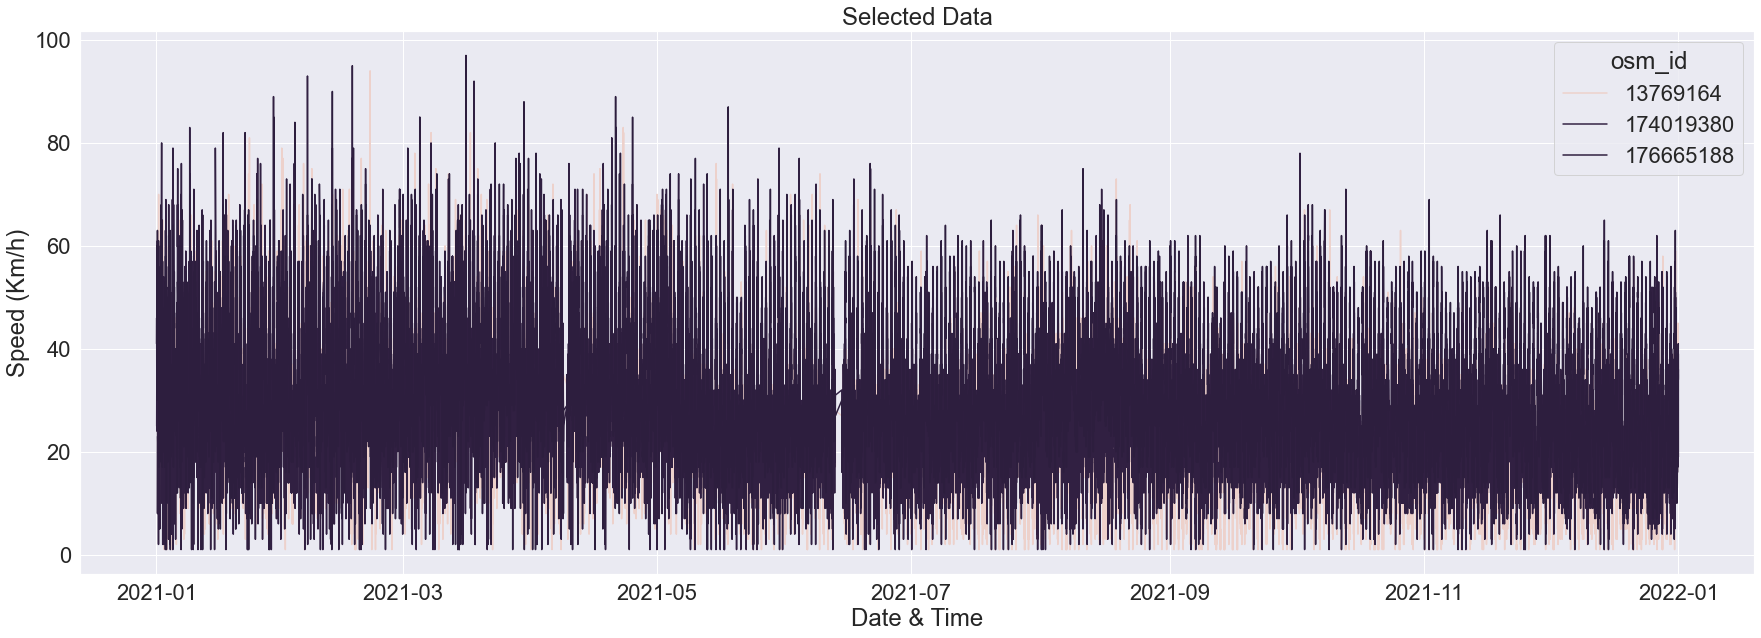

In [9]:
sns.set(rc={'figure.figsize':(30,10)}, font_scale=2)
sns.lineplot(x=df['date_time'], y=df['speed_kmph'], hue=df['osm_id']) # x=df.index, for single road segment
plt.ylabel('Speed (Km/h)')
plt.xlabel('Date & Time')
plt.title('Selected Data')

In [10]:
"""
CODE DUMP:

df['is_weekend'] = ''
df['is_weekday'] = ''

for i in range(len(df)):
    check = df.iat[i,6]
    if df.iat[i,6] != 1 and df.iat[i,6] != 7:
        df.iat[i,13] = 0
        df.iat[i,14] = 1
    else:
        df.iat[i,13] = 1
        df.iat[i,14] = 0

df = df.astype({"is_weekend":'int', "is_weekday":'int'})
"""

# Split df into X and y
# selecting the prediction target (label)
y = df.speed_kmph
    
# convert all the features with label encoder
df['highway_n'] = LabelEncoder().fit_transform(df['highway'])
df['bus_stop_n'] = LabelEncoder().fit_transform(df['bus_stop'])

"""
CODE DUMP:
Feature encoder
Because the data have been prepared accordingly for day, month and stores
df['n_time_n'] = LabelEncoder().fit_transform(df['n_time'])
df['n_day_n'] = LabelEncoder().fit_transform(df['n_day'])
df['n_month_n'] = LabelEncoder().fit_transform(df['n_month'])
df['stores_n'] = LabelEncoder().fit_transform(df['stores'])

For selecting features:
- One month data (one segments): data_features = ['hours', 'mins', 'n_day', 'stores']
- One month data (mult. segments): data_features = ['osm_id', 'hours', 'mins', 'n_day', 'stores','road_lt_m', 'bus_stop_n']
- Mult. month data (one segments): data_features = ['hours', 'mins', 'n_day', 'n_month', 'stores']
- Mult. month data (mult. segments): data_features = ['osm_id', 'hours', 'mins', 'n_day', 'n_month', 'stores', 'road_lt_m', 'bus_stop_n']
"""

# selecting the 'features', depending on the data
data_features = ['osm_id', 'hours', 'mins', 'n_day', 'n_month', 'stores', 'road_lt_m', 'bus_stop_n']
X = df[data_features]

X.head()

,osm_id,hours,mins,n_day,n_month,stores,road_lt_m,bus_stop_n
0,13769164,6,0,6,1,0,72.0,0
1,13769164,6,1,6,1,0,72.0,0
2,13769164,6,3,6,1,0,72.0,0
3,13769164,6,5,6,1,0,72.0,0
4,13769164,6,6,6,1,0,72.0,0


In [11]:
# Inspect the data
print('DATA INSPECTION RESULTS:')
print('osm id values:', df['osm_id'].unique())
print('day values:', df['n_day'].unique())
print('month values:', df['n_month'].unique())
print('stores values:', df['stores'].unique())
print('link_dir values:', df['link_dir'].unique())
print('highway values:', df['highway'].unique())
print('year values:', df['year'].unique())

DATA INSPECTION RESULTS:
osm id values: [ 13769164 174019380 176665188]
day values: [6 7 5 4 3 2 1]
month values: [ 1  2  3  4  5  6  7  8  9 10 11 12]
stores values: [0 1 2 3]
link_dir values: [1.]
highway values: ['primary']
year values: [2021]


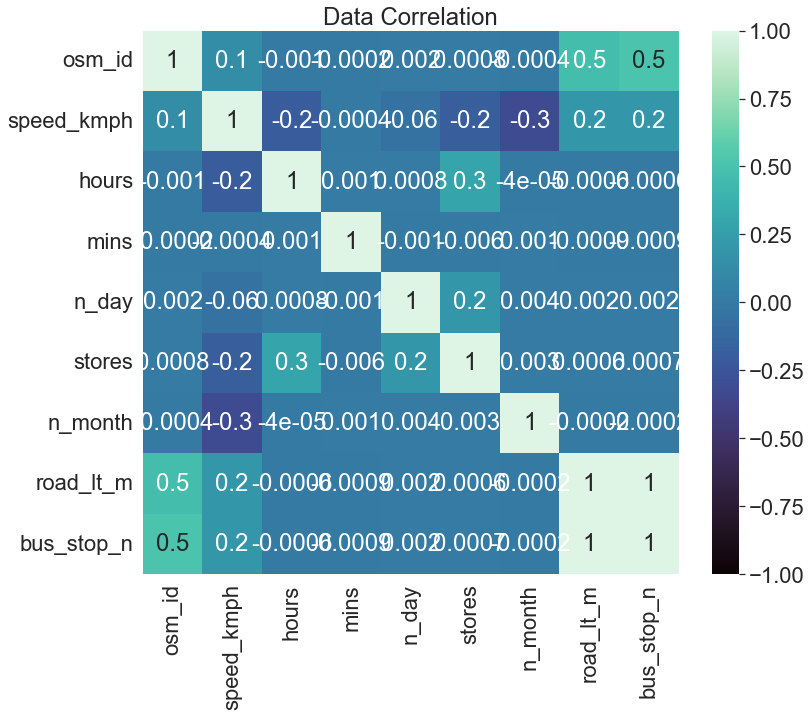

In [12]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)

# Visualizing Correlation
sns.set(rc={'figure.figsize':(12,10)}, font_scale=2)
sns.heatmap(df.corr(), annot=True, vmin=-1.0, cmap='mako', fmt='.1g')
plt.title('Data Correlation')
plt.show()

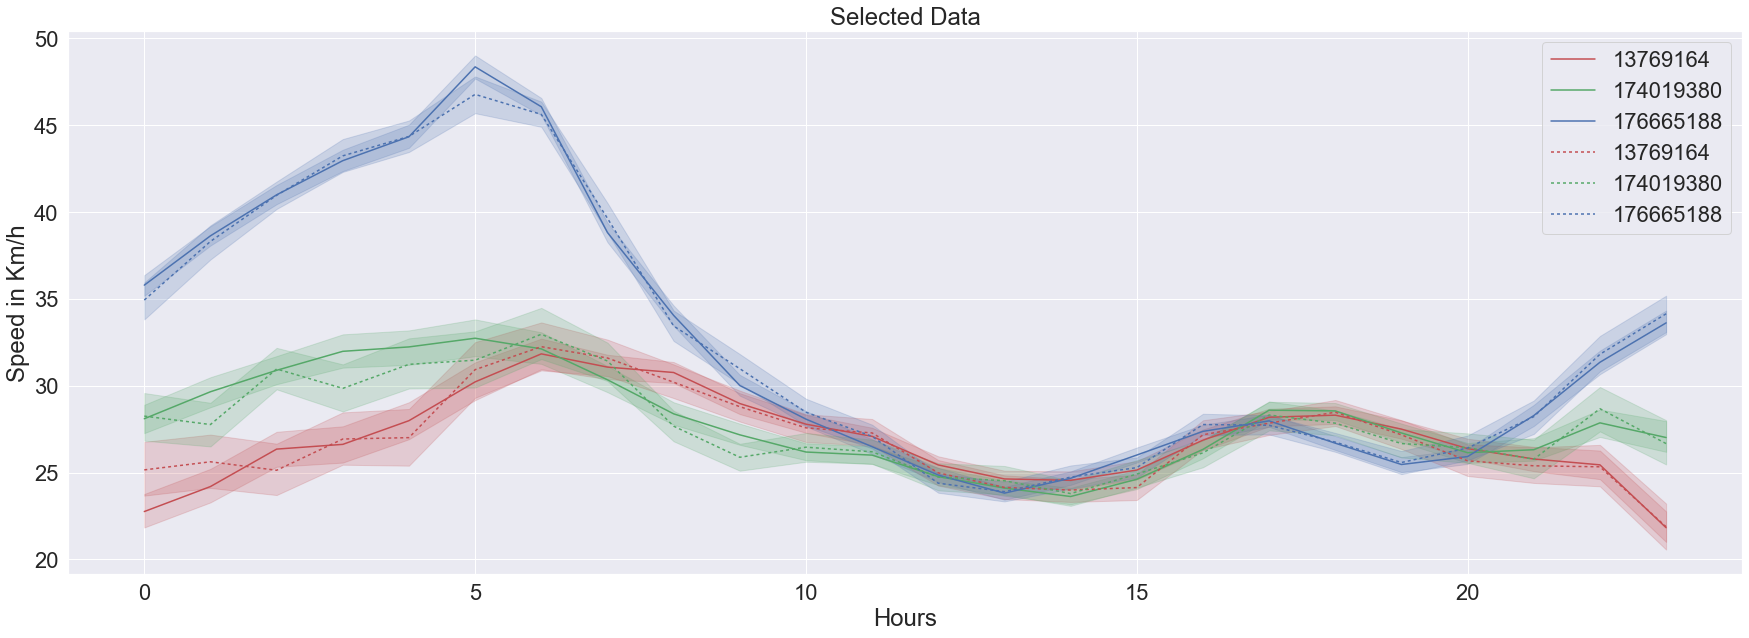

In [13]:
# Train-test split
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette("hls", 8))

sns.set(rc={'figure.figsize':(30,10)}, font_scale=2)
ax = sns.lineplot(x=train_X['hours'], y=train_y, hue=train_X['osm_id'], palette=['r', 'g', 'b']) # , label='Training Data', hue=train_X['osm_id']
ax = sns.lineplot(x=val_X['hours'], y=val_y, style=val_X['osm_id'], dashes=[(2,2), (2,2), (2,2)], hue=val_X['osm_id'], palette=['r', 'g', 'b']) # , label='Test Data', hue=val_X['osm_id'], palette=customPalette

# Customize the axes and title
ax.set_title("Selected Data")
ax.set_xlabel("Hours")
ax.set_ylabel("Speed in Km/h")
plt.legend(loc='upper right')

In [14]:
# Scale X
print('Variance before scaler:', train_X.var(), sep='\n')
print('\n')
scaler = StandardScaler()
scaler.fit(train_X)
train_X = pd.DataFrame(scaler.transform(train_X), index=train_X.index, columns=train_X.columns)
val_X = pd.DataFrame(scaler.transform(val_X), index=val_X.index, columns=val_X.columns)

print('Variance after scaler:', train_X.var(), sep='\n')
print('\n')

print(train_X)
print(val_X)
print(train_y)
print(val_y)

Variance before scaler:
osm_id        5.788549e+15
hours         4.726473e+01
mins          2.643637e+02
n_day         3.962345e+00
n_month       1.187759e+01
stores        6.038649e-01
road_lt_m     5.253396e+04
bus_stop_n    2.226585e-01
dtype: float64


Variance after scaler:
osm_id        1.000014
hours         1.000014
mins          1.000014
n_day         1.000014
n_month       1.000014
stores        1.000014
road_lt_m     1.000014
bus_stop_n    1.000014
dtype: float64


          osm_id     hours      mins     n_day   n_month    stores  road_lt_m  \
3694   -1.419233  0.802074  0.455759 -1.011167 -1.311907  0.489745  -0.642538   
70     -1.419233  0.220247 -1.020332  0.998328 -1.602067 -0.797121  -0.642538   
103981  0.721826 -0.216124  1.378317 -1.011167  1.589702  0.489745   1.408061   
66436   0.687050 -0.507038 -0.466798 -0.006419  1.299541  1.776610  -0.773428   
55169   0.687050  1.674816  0.455759  0.495954  0.138898 -0.797121  -0.773428   
...          ...       ...       

# Model Links
- LR    : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- KNN   : https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html?highlight=kneighborsregressor#sklearn.neighbors.KNeighborsRegressor
- MLP   : https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
- SVR   : https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html or https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html
- DT    : https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
- RF    : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- GB    : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

Additional about R2 negative
https://stats.stackexchange.com/questions/183265/what-does-negative-r-squared-mean#:~:text=R2%20can%20be%20negative,fits%20your%20data%20very%20badly

In [ ]:
# Comparing the models 
models = {
    "                     Linear Regression": LinearRegression(), # normalize=True
    "                   K-Nearest Neighbors": KNeighborsRegressor(), # n_neighbors=5, weights='uniform', algorithm='brute', p=1
    "                        Neural Network": MLPRegressor(), # max_iter=500, random_state=0, solver='lbfgs'
    "Support Vector Machine (Linear Kernel)": LinearSVR(), # C=1, epsilon=5
    "   Support Vector Machine (RBF Kernel)": SVR(), # C=500, epsilon=5
    "                         Decision Tree": DecisionTreeRegressor(), # max_depth=6
    "                         Random Forest": RandomForestRegressor(), # max_depth=6, max_features="log2", random_state=0
    "                     Gradient Boosting": GradientBoostingRegressor() # n_estimators=100, learning_rate=0.1, max_depth=3
}

for name, model in models.items():
    model.fit(train_X, train_y)
    print(name + " trained.")

In [ ]:
for name, model in models.items():
    print(name + " R^2 Score: {:.5f}".format(model.score(val_X, val_y)))
    print(name + " R^2 Score: {:.5f}".format(model.score(train_X, train_y)))

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

for name, model in models.items():
    val_predict = model.predict(val_X)
    print(name + " R^2 Score: {:.5f}".format(r2_score(val_y, val_predict)))
    print(name + " RMSE: {:.5f}".format(np.sqrt(mean_squared_error(val_y, val_predict))))
    print(name + " MAE: {:.5f}".format(mean_absolute_error(val_y, val_predict)))

In [15]:
# Specifying and creating the MODEL
# Change the model accordingly!
data_model = GradientBoostingRegressor()
data_model.fit(train_X, train_y)

GradientBoostingRegressor()

In [16]:
# PREDICTING and VALIDATING the values
val_predict = data_model.predict(val_X)

print('R^2 Score =', r2_score(val_y, val_predict))
print('Mean Absolute Error =', mean_absolute_error(val_y, val_predict))
print('Root Mean Squared Error =', np.sqrt(mean_squared_error(val_y, val_predict)))

# Implementing Cross Validation techniques
from sklearn.model_selection import cross_val_score
scores = cross_val_score(data_model, train_X, train_y, cv=10)
scores

R^2 Score = 0.45837560134215083
Mean Absolute Error = 6.506787613072447
Root Mean Squared Error = 8.748963208713597


array([0.46981399, 0.46953866, 0.46186104, 0.45897931, 0.46666885,
       0.48114893, 0.47546638, 0.47927507, 0.45670515, 0.46037944])

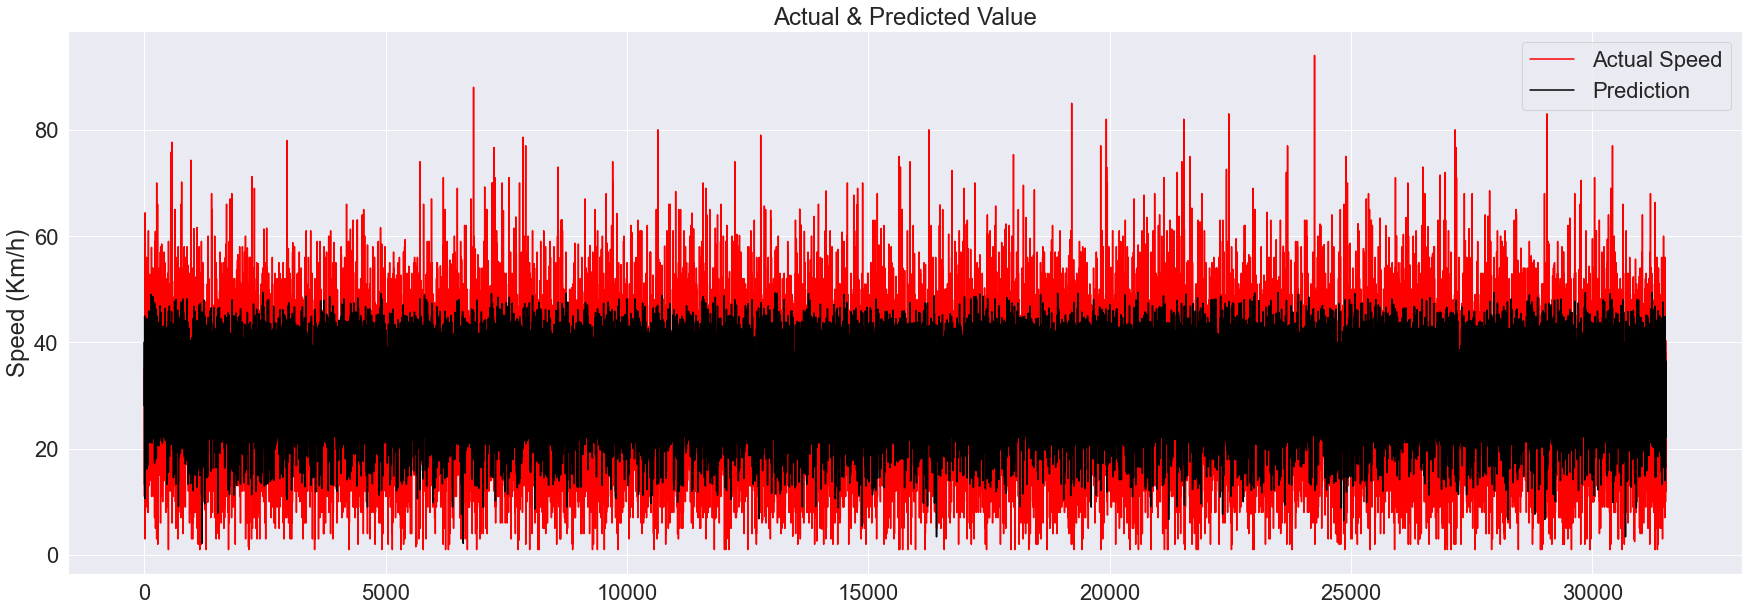

In [17]:
plt.figure(figsize=(30,10))
n=len(val_y)
plt.plot(range(n), val_y, color = 'red', label = 'Actual Speed')
plt.plot(range(n), val_predict, color = 'black', label = 'Prediction')
plt.legend(loc = 'best')
plt.ylabel('Speed (Km/h)')
plt.title('Actual & Predicted Value')
plt.show()

In [18]:
# Inverse transform the X data for plot

print('Before Inverse Scaler:')
print("Training Data", train_X)
print("Test Data", val_X)

train_X = pd.DataFrame(scaler.inverse_transform(train_X), index=train_X.index, columns=train_X.columns)
val_X = pd.DataFrame(scaler.inverse_transform(val_X), index=val_X.index, columns=val_X.columns)

print("After Inverse Scaler:")
print("Training Data", train_X)
print("Test Data", val_X)

Before Inverse Scaler:
Training Data           osm_id     hours      mins     n_day   n_month    stores  road_lt_m  \
3694   -1.419233  0.802074  0.455759 -1.011167 -1.311907  0.489745  -0.642538   
70     -1.419233  0.220247 -1.020332  0.998328 -1.602067 -0.797121  -0.642538   
103981  0.721826 -0.216124  1.378317 -1.011167  1.589702  0.489745   1.408061   
66436   0.687050 -0.507038 -0.466798 -0.006419  1.299541  1.776610  -0.773428   
55169   0.687050  1.674816  0.455759  0.495954  0.138898 -0.797121  -0.773428   
...          ...       ...       ...       ...       ...       ...        ...   
50057   0.687050  0.802074  0.455759 -1.513540 -0.151263 -0.797121  -0.773428   
98047   0.721826  0.511161 -0.466798 -0.508793  1.009380  0.489745   1.408061   
5192   -1.419233 -0.507038 -1.389355 -0.006419 -1.311907  1.776610  -0.642538   
77708   0.721826  0.947531  0.455759 -1.513540 -1.021746 -0.797121   1.408061   
98539   0.721826  0.947531 -0.466798 -1.513540  1.009380 -0.797121   1.4

Text(0, 0.5, 'Speed (Km/h)')

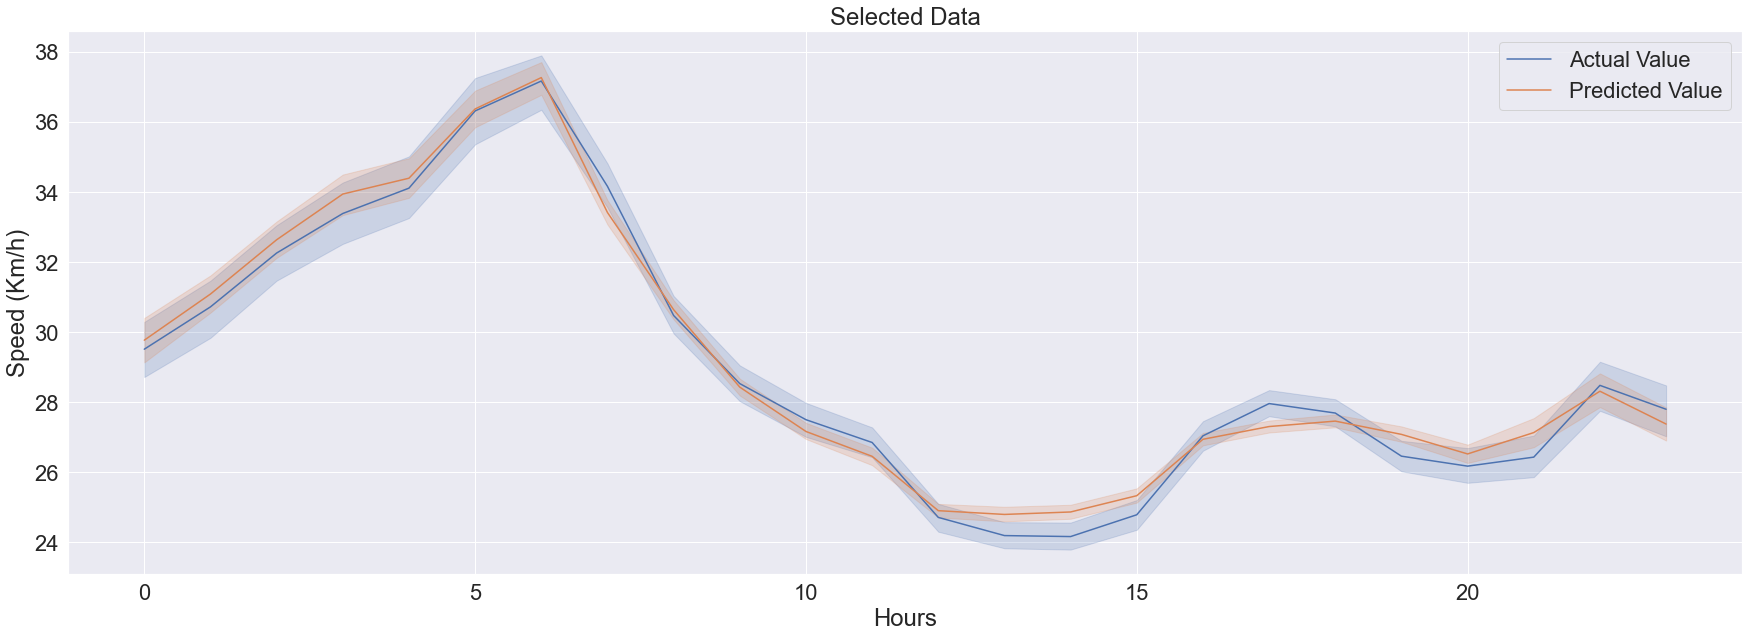

In [19]:
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette("hls", 8))

ax = sns.set(rc={'figure.figsize':(30,10)}, font_scale=2)
ax = sns.lineplot(x=val_X['hours'], y=val_y, label='Actual Value') # , hue=train_X['osm_id']
ax = sns.lineplot(x=val_X['hours'], y=val_predict, label='Predicted Value') # , hue=val_X['osm_id'], palette=customPalette

# Customize the axes and title
ax.set_title("Selected Data")
ax.set_xlabel("Hours")
ax.set_ylabel("Speed (Km/h)")

Text(0, 0.5, 'Speed (Km/h)')

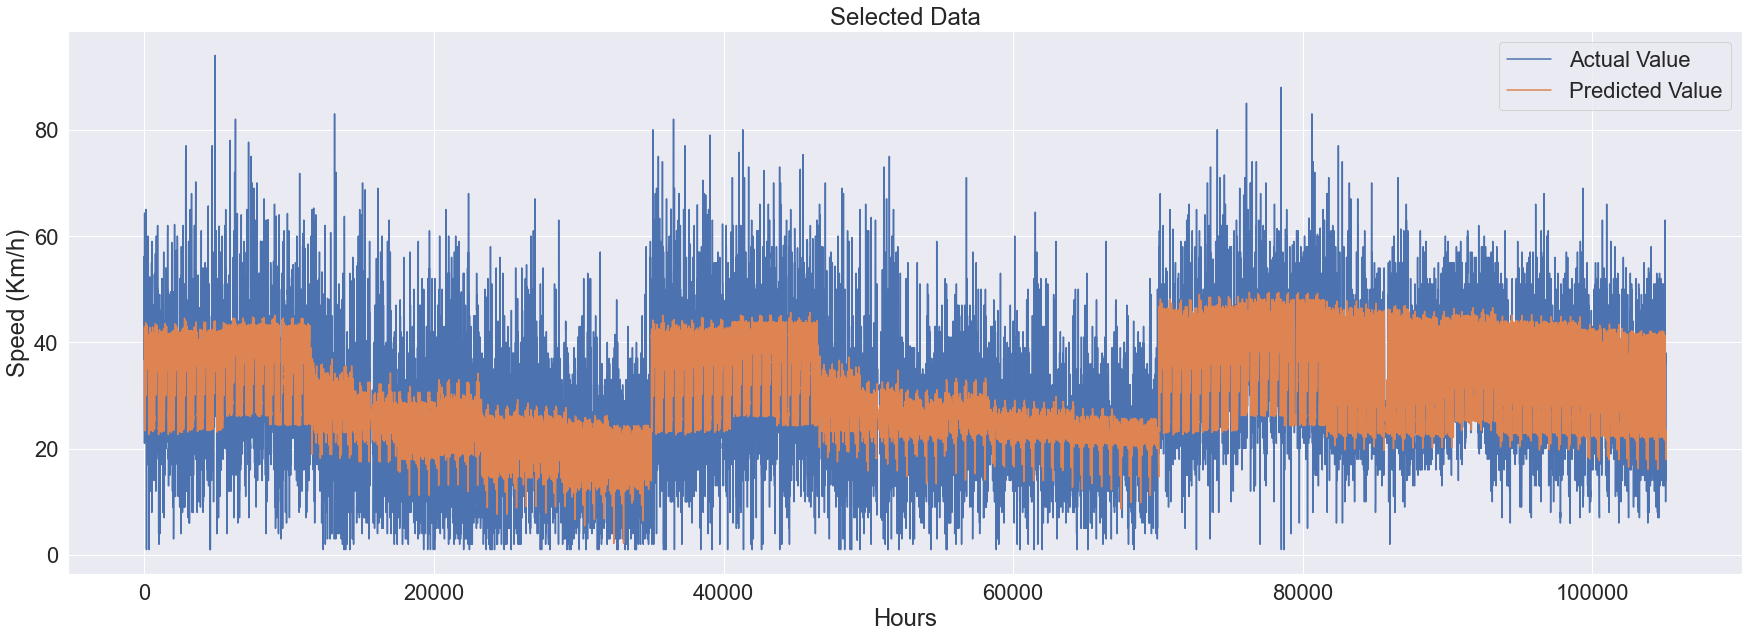

In [20]:
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette("hls", 8))

ax = sns.set(rc={'figure.figsize':(30,10)}, font_scale=2)
ax = sns.lineplot(x=val_X.index, y=val_y, label='Actual Value') # , hue=train_X['osm_id']
ax = sns.lineplot(x=val_X.index, y=val_predict, label='Predicted Value') # , hue=val_X['osm_id'], palette=customPalette

# Customize the axes and title
ax.set_title("Selected Data")
ax.set_xlabel("Hours")
ax.set_ylabel("Speed (Km/h)")

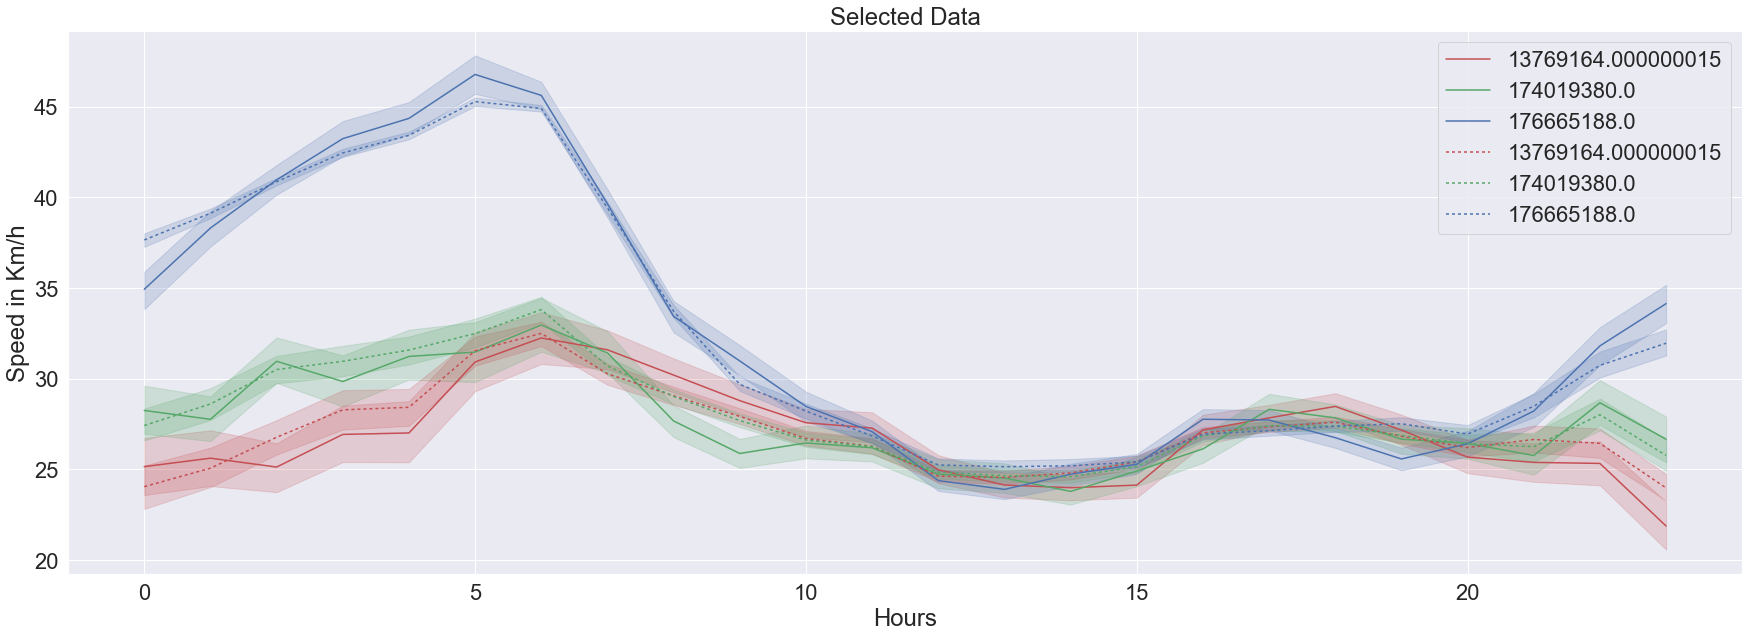

In [21]:
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette("hls", 8))

sns.set(rc={'figure.figsize':(30,10)}, font_scale=2)
ax = sns.lineplot(x=val_X['hours'], y=val_y, hue=val_X['osm_id'], palette=['r', 'g', 'b']) # , label='Training Data', hue=train_X['osm_id']
ax = sns.lineplot(x=val_X['hours'], y=val_predict, style=val_X['osm_id'], dashes=[(2,2), (2,2), (2,2)], hue=val_X['osm_id'], palette=['r', 'g', 'b']) # , label='Test Data', hue=val_X['osm_id'], palette=customPalette

# Customize the axes and title
ax.set_title("Selected Data")
ax.set_xlabel("Hours")
ax.set_ylabel("Speed in Km/h")
plt.legend(loc='upper right')